In [1]:
#-----------------------------------------parameter-----------------------------------------
# min_shared_counts = 10 | 删除没有同时有10个spliced and unspliced counts的基因
# n_top_genes = 3000 | 取top 多少的high variable gene (这些基因被认为是更能生物学差异的)
# n_pcs=30 | 使用的PC数
# n_neighbors=20 | 临近细胞的数量
# min_likelihood | Minimal likelihood for velocity genes to fit the model on
# min_likelihood_time | Minimal likelihood fitness for genes to be included to the weighting
# size | 图片大小
#-----------------------------------------parameter-----------------------------------------

In [1]:
##先激活虚拟环境
#### env : conda activate scvelo

In [2]:
#-----------------------加载相关的包--------------------------------------------
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
import IPython
import cellrank as cr
import scanpy as sc
#-----------------------加载相关的包--------------------------------------------

In [8]:
#----------------一些进程还有画图参数设置----------------------------
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',dpi=150,dpi_save=300)
#----------------一些进程还有画图参数设置--------------------------------

In [3]:
#----------------读入spliced counts---------------------------------
s = scv.read("./spliced.csv")
s
#----------------读入spliced counts---------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084

In [4]:
#----------------读入unspliced counts---------------------------------
u = scv.read("./unspliced.csv")
u
#----------------读入unspliced counts---------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084

In [5]:
#------------------------组合成anndata object-----------------------------------------
adata = s
adata.layers['spliced'] = s.X
adata.layers['unspliced'] = u.X
adata
#------------------------组合成anndata object-----------------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084
    layers: 'spliced', 'unspliced'

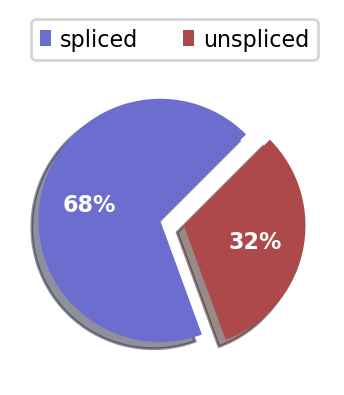

In [6]:
#----------------------------------unspliced coounts 的比例，一般要在15%以上---------------------
scv.pl.proportions(adata)
#----------------------------------unspliced coounts 的比例，一般要在15%以上---------------------

In [7]:
#---------------------------------读入metadata-----------------------------
m = pd.read_csv("./metadata.csv")
m
#---------------------------------读入metadata-----------------------------

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rps,percent.rpl,percent.rrna,nCount_SCT,nFeature_SCT,...,HLA1,Donor.orig,Donor.full,Donor,Status,Sex,DPS,DTF,Admission,Ventilated
0,covid_555_1.2,covid_555_1,1099,160,13.102821,0.363967,0.363967,58.780710,1700,160,...,0.023525,555,C1 A,C1,COVID,M,9,9,ICU,NonVent
1,covid_555_1.3,covid_555_1,1055,212,2.938389,0.663507,0.947867,55.829384,1661,213,...,-0.044271,555,C1 A,C1,COVID,M,9,9,ICU,NonVent
2,covid_555_1.7,covid_555_1,2411,312,10.908337,0.041477,0.165906,67.399419,1971,312,...,-0.038040,555,C1 A,C1,COVID,M,9,9,ICU,NonVent
3,covid_555_1.8,covid_555_1,2276,336,11.203866,0.263620,0.307557,67.355009,1948,336,...,-0.043605,555,C1 A,C1,COVID,M,9,9,ICU,NonVent
4,covid_555_1.11,covid_555_1,1166,351,5.060034,0.686106,1.114923,36.277873,1619,351,...,-0.071987,555,C1 A,C1,COVID,M,9,9,ICU,NonVent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3182,HIP045.2186,HIP045,4218,1073,4.338549,1.991465,3.082029,17.567568,2492,926,...,-0.107606,HIP045,H6,H6,Healthy,M,0,0,NaN,Healthy
3183,HIP045.2210,HIP045,2264,1097,12.234982,3.842756,5.962898,14.796820,2119,1097,...,-0.149190,HIP045,H6,H6,Healthy,M,0,0,NaN,Healthy
3184,HIP045.2233,HIP045,3032,1114,9.300792,3.199208,3.924802,14.808707,2318,1108,...,-0.091390,HIP045,H6,H6,Healthy,M,0,0,NaN,Healthy
3185,HIP045.2426,HIP045,3787,1430,11.169791,3.512015,4.357011,12.094006,2527,1367,...,-0.114220,HIP045,H6,H6,Healthy,M,0,0,NaN,Healthy


In [3]:
#----------------------------------读入细胞UMAP 坐标-----------------------------
umap = pd.read_csv('./cell_embeddings.csv')
umap
umap = umap.iloc[:,1:]
umap
#----------------------------------读入细胞UMAP 坐标-----------------------------

,Unnamed: 0,UMAP_1,UMAP_2
0,covid_555_1.2,0.088325,-1.833405
1,covid_555_1.3,-0.202251,4.213624
2,covid_555_1.7,-2.638725,2.088745
3,covid_555_1.8,-1.338910,-6.483031
4,covid_555_1.11,-2.370549,-9.392575
...,...,...,...
3182,HIP045.2186,0.570493,-3.560979
3183,HIP045.2210,4.090896,-2.805602
3184,HIP045.2233,-5.576463,2.649315
3185,HIP045.2426,-4.389531,2.005273


In [10]:
#---------------------------------------赋值到object中-------------------------------------
adata.obsm['X_umap'] = umap.values
adata.obsm['X_umap']
#---------------------------------------赋值到object中-------------------------------------

array([[ 0.08832481, -1.83340495],
       [-0.20225141,  4.21362366],
       [-2.63872478,  2.08874525],
       ...,
       [-5.57646344,  2.64931454],
       [-4.38953087,  2.00527276],
       [-0.38245687, -2.86115866]])

In [13]:
#------------------------------------------------写出数据--------------------------------------------
adata.write('./Covid19.h5ad', compression='gzip')
#------------------------------------------------写出数据--------------------------------------------

... storing 'Donor.orig' as categorical
... storing 'Donor.full' as categorical
... storing 'Donor' as categorical
... storing 'singler' as categorical
... storing 'cell.type.fine' as categorical


In [3]:
#-----------------------------------读入已经保存的数据-----------------------------------------
adata = scv.read('./Covid19.h5ad')
#-----------------------------------读入已经保存的数据-----------------------------------------

In [4]:
#---------------------看一些数据结构-------------------------------------------------
adata
#---------------------看一些数据结构-------------------------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084
    obs: 'Donor.orig', 'Donor.full', 'Donor', 'seurat_clusters', 'singler', 'cell.type.fine'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [5]:
#--------------------------------------Preprocess------------------------------------------
min_shared_counts = 10
n_top_genes = 3000
scv.pp.filter_and_normalize(adata, min_shared_counts=min_shared_counts, n_top_genes=n_top_genes)

n_pcs=30
n_neighbors=20
scv.pp.moments(adata, n_pcs=n_pcs, n_neighbors=n_neighbors)

scv.tl.recover_dynamics(adata)

min_likelihood=0.001

scv.tl.velocity(adata, min_likelihood=min_likelihood)
#--------------------------------------Preprocess------------------------------------------

Filtered out 17389 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:01:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


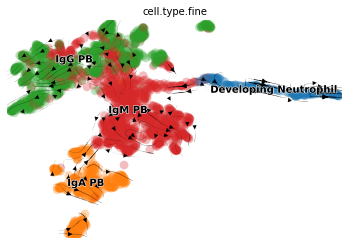

computing terminal states
    identified 0 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


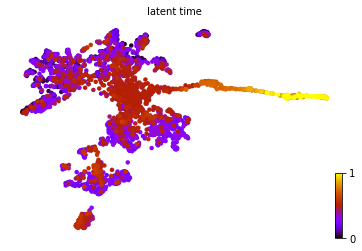

In [7]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap',color='cell.type.fine')

#####latent time
#scv.tl.terminal_states(adata)
min_likelihood_time=0.1

scv.tl.latent_time(adata, min_likelihood=min_likelihood_time)

size = 80
scv.pl.scatter(adata, color='latent_time',color_map='gnuplot', size=size)